<h1><center>Solving the Tube Challenge with Reinforcement Learning</center></h1> 

<center><h2> Table of Content</h2> </center>

* [Introduction](#first-bullet) 
* [Data description](#second-bullet)
* [Data processing](#third-bullet)
* [Random Policy](#fourth-bullet)
* [Q learning](#fourth-bullet)
* [Double Q learning](#fith-bullet)
* [Deep Q learning?](#fith-bullet)
* [Conclusion](#sixth-bullet)


   

### Introduction <a class="anchor" id="first-bullet"></a>


Our aim in this project is to use Reinforcement Learning to complete a slightly modified version of the Tube Challenge. 

To complete the Tube Challenge, one must simply travel to all London Underground stations as fast as possible. To do so, the particpant may connect stations on foot, or by using other forms of public transport. In its core however, this challenge is a routing problem where participants must come up with the fastest and most efficient path to navigate the tube network. This competition has drawn a lot of attention over the years and the best performances are even tracked as a Guinness World Record since 1960.

Below is a table showing the record holders that have appeared in the printed edition of the Guinness Book of Records

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://en.wikipedia.org/wiki/Tube_Challenge'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'lxml')
table1 = soup.find('table')
headers = []

for i in table1.find_all('th'):
    title = i.text[:-1]
    headers.append(title)
mydata = pd.DataFrame(columns = headers)

for j in table1.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [i.text[:-1] for i in row_data]
    length = len(mydata)
    mydata.loc[length] = row
mydata[10:]

,Date,Record Holder(s),Stations,Time
10,20 May 1980,John Trafford and Stephen Trafford[12],278,"18 hours, 3 minutes"
11,3 December 1981,Colm Mulvany[13],277,"17 hours, 37 minutes"
12,22 July 1982,Peter Robinson (youngest person to tour all st...,277,Not given
13,14 April 1986,"Robert Robinson, Peter David Robinson, John Ga...",272,"19 hours, 51 minutes, 14 seconds"
14,30 July 1986,"Robert Robinson, Peter David Robinson, Timothy...",272,"18 hours, 41 minutes, 41 seconds"
15,4 October 1994,Robert Robinson and Tom McLaughlin[17],270,"18 hours, 18 minutes, 9 seconds"
16,16 March 2000,"Robert Robinson, Chris Loxton, Chris Stubley, ...",272,"19 hours, 57 minutes, 47 seconds"
17,26 September 2006,Håkan Wolgé and Lars Andersson[19],275,"18 hours, 25 minutes, 3 seconds"
18,1 October 2013,Geoff Marshall and Anthony Smith [20],270,"16 hours, 20 minutes, 27 seconds"
19,21 May 2015,Steve Wilson and AJ [21],270,"15 hours, 45 minutes, 38 seconds"


#### Travelling Salesman Problem

The Tube Challenge is a generalisation of the famous Travelling Salesman Problem (TSP) which is a typical optimization problem, where one has to find the shortest route to visit different locations. TSP are np-hard problems, meaning that they are exponentially hard to solve with brute force. To go pass this issue, many optimization techniques exist to solve TSPs from dynamic programming, branch and bound algorithms to nearest neighbors approximations or colonies optimizations.

#### Why use Reinforcement Learning
Eventhough TSPs can be solved, Reinforcement Learning theoretically holds many advantages compared to classical optimization techniques :

- It offers a general framework for all problems
- It enables a "live" decision making algorithm
- It is more robust to unknowns and aleatory perturbations

#### The setup of our Tube Challenge

Implementing the Tube Challenge poses some noteworthy difficulties:

- Allowing for multiple modes of transport (walking and other public transport) is very challenging, as it adds layers of complexity and unknown variables to an already complex problem
- No reliable data exist on the time it takes to go from one station to another
- Not accounting for the cost (in time) of changing line could lead to a big bias in our final optimal path

Henceforth, the setup of our project is slightly different from the classic Tube Challenge:

- We will work with all of the 274 stations of the tube network 
- The tube will be the only mode of transport allowed to complete the challenge
- Distance will be used as a proxy for time 
- We will Implement an arbitrary 1km penalty (the average distance between 2 stations) for changing lines

This project is structured in the following way,

First, we model the tube network using real life data on the tube stations, lines and their connections. We then use this network to build a function that finds the shortest route between any two stations.  Then, we implement a random policy and obtain the average distance and number of steps an agent could expect to take before completing the Tube Challenge. Subsequently, we compare these results with the results we obtain from our Q learning and double Q learning algorithms. We show that they exhibit significantly better performances and we finally use our shortest route function to unpack the optimal path from our algorithms. We conclude by interpreting our results and comparing them to real life results and strategies.

#The key to solving the Tube Challenge is to view it as a slightly modified TSP.

### Data description <a class="anchor" id="second-bullet"></a>

The data we will be using to build our model is made available by Wikimedia Commons [London Underground geographic maps](https://commons.wikimedia.org/wiki/London_Underground_geographic_maps). It is composed of three different CSV files defining the stations, the lines and the routes of the London Tube.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#os.chdir('drive/My Drive/RLproject')

In [4]:
stations = pd.read_csv('/Users/adriensourdille/Desktop/Tube_challenge/stations.txt')
routes = pd.read_csv('/Users/adriensourdille/Desktop/Tube_challenge/routes.txt')
line_definitions = pd.read_csv('/Users/adriensourdille/Desktop/Tube_challenge/line_definitions.txt')

In [5]:
print("Number of stations:", len(stations))
print("Number of lines:", len(routes))
print("Number of connections:", len(line_definitions))

Number of stations: 308
Number of lines: 13
Number of connections: 415


In [6]:
stations.describe()

,id,latitude,longitude,zone,total_lines,rail
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,154.889610,51.533676,-0.151967,2.917208,1.363636,0.162338
std,89.469123,0.050572,0.150825,1.626470,0.751270,0.369360
min,1.000000,51.402200,-0.611000,1.000000,1.000000,0.000000
25%,77.750000,51.502700,-0.236600,2.000000,1.000000,0.000000
50%,154.500000,51.522200,-0.143350,2.500000,1.000000,0.000000
75%,232.250000,51.562450,-0.047600,4.000000,1.000000,0.000000
max,309.000000,51.705200,0.251000,9.000000,6.000000,1.000000


The London Tube is divided in 9 zones, 13 lines and 308 stations. These include railroad stations that we will remove later on as they are not part of the Tube Challenge. The stations dataset includes the location (latitude and longitude) of these stations as well as their names and the zone they belong to. 

#### Building our network

We will now build the tube network with the data we just acquired.

In [7]:
#Here, we add connections between the stations of the tube in order to build a connected tube network
connections = pd.DataFrame(columns=['line',	'line_name','line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station1_zone', 'station1_total_lines',	'station1_rail', 'station2', 'station2_name', 'station2_long','station2_lat', 'station2_zone', 'station2_total_lines',	'station2_rail'])
connections = connections.iloc[0:0]

In [8]:
for index, row in line_definitions.iterrows():
    connections = connections.append({'line': row[2],
                                    'line_name': routes[routes['line']==row[2]]['name'].item(),
                                    'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                    'station1': row[0],
                                    'station1_name': stations[stations['id']==row[0]]['name'].item(),
                                    'station1_long': stations[stations['id']==row[0]]['longitude'].item(),
                                    'station1_lat': stations[stations['id']==row[0]]['latitude'].item(),
                                    'station1_zone': stations[stations['id']==row[0]]['zone'].item(),
                                    'station1_total_lines': stations[stations['id']==row[0]]['total_lines'].item(),
                                    'station1_rail': stations[stations['id']==row[0]]['rail'].item(),
                                    'station2': row[1],
                                    'station2_name': stations[stations['id']==row[1]]['name'].item(),
                                    'station2_long': stations[stations['id']==row[1]]['longitude'].item(),
                                    'station2_lat': stations[stations['id']==row[1]]['latitude'].item(),
                                    'station2_zone': stations[stations['id']==row[1]]['zone'].item(),
                                    'station2_total_lines': stations[stations['id']==row[1]]['total_lines'].item(),
                                    'station2_rail': stations[stations['id']==row[1]]['rail'].item(),
                                    }, ignore_index=True)


In [12]:
edgelist = connections[['station1', 'station2', 'line_colour']]
nodelist = stations[['id','latitude','longitude']]

#### Graphing our network

In [13]:
import networkx as nx

g = nx.Graph()
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())
for i, nlrow in nodelist.iterrows():
    nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})  

In [14]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}
node_positions = {node[0]: (node[1]['longitude'], node[1]['latitude']) for node in list(g.nodes(data=True))}

In [15]:
#Convert HEX colours to RGB colours
line_colours = {
        'ab6612': (171, 102, 18),
        '0076bd': (0, 118, 189),
        'f7dc00': (247, 220, 0),
        'f5a6b3': (245, 166, 179),
        '767b7f': (118, 123, 127),
        '0d6928': (0, 114, 41),
        'df002c': (220, 36, 31),
        '8b004c': (117, 16, 86),
        'f3ba22': (243, 186, 34),
        '000000': (0, 0, 0),
        '002d73': (0, 45, 115),
        '89cbc1': (137, 203, 193),
        '00A77E':(0,167,126)
}

# Convert RGB colours to [0,1] scale
line_colours = {line: tuple([x / 255.0 for x in rgb]) for line, rgb in line_colours.items()}

# Set these as options for drawing graph
options = {
    'edge_color': [line_colours[data['line_colour']] for u,v,data in g.edges(data=True)],
    'width': 1.5,
    'alpha': 1,
}

<function matplotlib.pyplot.show(close=None, block=None)>

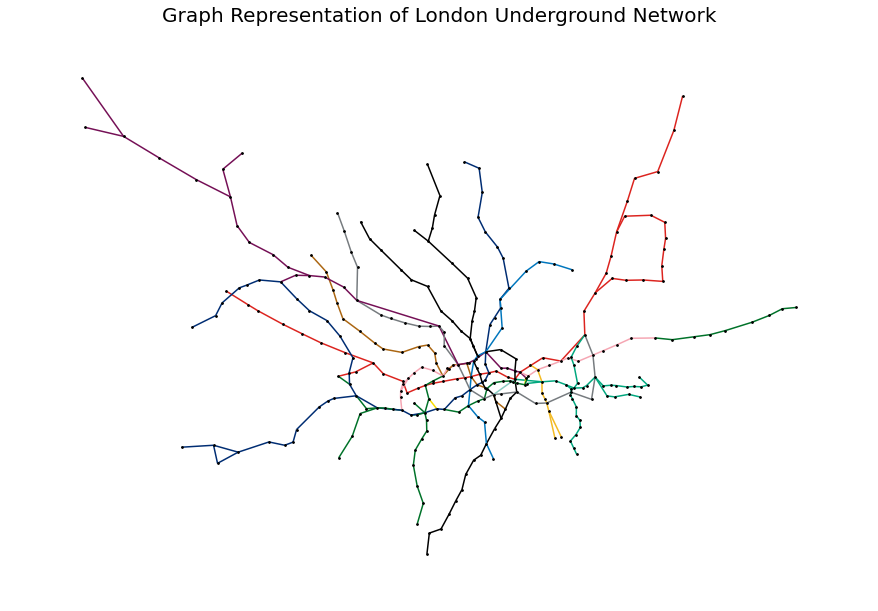

In [16]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, node_size=3, node_color='black', **options)
plt.title('Graph Representation of London Underground Network', size=20)
plt.show

We managed to graph the entire tube network and differentiate the lines by colour. Each point in the graph represents a station. 

Some lines in the graph seem to change colour unexplainably which can cause some confusion. This can be explained by the fact that, at times, some lines share the same tracks. For instance, the Hammersmith and city line (pink) shares a common track with the District line (green) from Barking station to Aldgate East station. In the graph however, this portion of the network is drawn in pink so that we could think it exclusively belongs to the Hammersmith and city line. 

### Data processing <a class="anchor" id="third-bullet"></a>

#### Calculating distance

Next we will use [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to calculate the point-to-point distance between the stations in the network by using the latitude and longitude coordinates of each station in the dataset.


In [18]:
from math import cos, asin, sqrt, pi
import statistics as st
import scipy.stats as stats

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

#### Finding the shortest route

We now construct a function to find the shortest route between two stations.

In [22]:
def shortest_route(start, end):
    journey_path = nx.shortest_path(graph_distance, start, end, weight='weight')
    journey_distance = nx.shortest_path_length(graph_distance, start, end, weight='weight')
    print(f'\nShortest-Tube-Distance Journey from {start} to {end}:', *journey_path, sep='\n\t')
    print('\nJourney Distance:', journey_distance, 'kilometers')

In [23]:
shortest_route('Canary Wharf', 'Covent Garden')


Shortest-Tube-Distance Journey from Canary Wharf to Covent Garden:
	Canary Wharf
	West India Quay
	Westferry
	Limehouse
	Shadwell
	Bank
	St. Paul's
	Chancery Lane
	Holborn
	Covent Garden

Journey Distance: 7.96831555899172 kilometers


Although the function is successfull in finding the shortest path between two stations, it is not necesserally successfull in finding the fastest way between these two stations. For instance, the Jubilee line goes directly from Canary Wharf to Covent Garden, and is the fastest option with Google Maps estimating the journey time at 30 minutes. 
The shortest route however, includes 2 changes (DLR ==> Central ==> Piccadily) and takes 34 min on Google Maps. We hence find that taking the shortest route might, at times, lenghten our journey time. 

This is an important finding which results from our assumption that distance can be used as a proxy for time. To resolve this issue, we will assign a weight to line changes so as to account for the loss of time resulting from them.
This penalty is calculated below and is equal to 1km.

#### Choosing the line change penalty

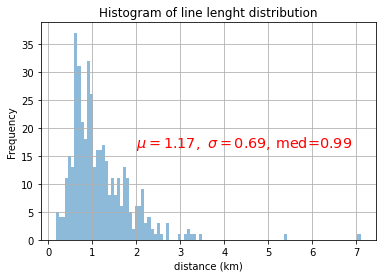

In [19]:
distances=[]
for index, row in connections.iterrows():
    distances.append(distance(row[6], row[5], row[13], row[12]))
connections['distance'] = distances

Distances = pd.DataFrame(distances) # Create a pandas DataFrame out of the numpy array
Distances.plot.hist(alpha=0.5, bins=100, grid=True, legend=None)  # Pandas helper function to plot a hist. Uses matplotlib under the hood.
plt.xlabel("distance (km)")
plt.title("Histogram of line lenght distribution")

param = stats.norm.fit(distances)   # calculate sigma and mu
st.median(distances) # calculate median
plt.text(2,16.5, r'$\mu=1.17,\ \sigma=0.69$, med=0.99', color='r', fontsize = 'x-large')

plt.show()

We have calculated the distance between each station in the graph and concluded that, on average, each station was separated by 1.17km. Because the distance between central stations is smaller than the distance between peripheric stations, we observe a positive skewness in the distance distribution. Furthermore, it is unlikely that participants will change lines in the periphery of the network. For this reason, we think it is more accurate to take the median distance as the penalty value for changing lines. 

The appropriate penalty for a line change will hence be 1km.

#### Transforming the problem into a TSP

With a few more processing steps, this problem can be reduced to the most basic TSP problem, in which the network is complete (each node is connected with one another), and each node can only be travelled to once. 

The intuition behind why each is node is connected: All the stations in the graph are directly connected between one another and the distance separating them is given by the shortest route function. 

The intuition behind why nodes are only travelled to once: Since the graph is complete, and the only reason for passing through a node more than once is to reach another node, it can be considered that, eventhough we might pass through a station multiple times, it is only travelled to once in reality. 


<h4> Splitting stations to station*line(platforms) to address transit cost </h4>

To add transit costs, we must consider that a station is composed of platforms that participants must travel to in order to transit from one line to the next. The distance between each platform in the station is arbitrarily set to 1km (the median distance between two station) and is used as a way to simulate the time lost in transiting from one line to the next.

In [24]:
stations_ = stations
stations_['line']=range(len(stations_.index))

In [25]:
two_lines = stations[stations['total_lines'] > 1]
three_lines = stations[stations['total_lines'] > 2]
four_lines = stations[stations['total_lines'] > 3]
five_lines = stations[stations['total_lines'] > 4]
six_lines = stations[stations['total_lines'] > 5]
stations_ = stations_.append([two_lines],ignore_index=True)
stations_ = stations_.append([three_lines],ignore_index=True)
stations_ = stations_.append([four_lines],ignore_index=True)
stations_ = stations_.append([five_lines],ignore_index=True)
stations_ = stations_.append([six_lines],ignore_index=True)

In [27]:
ilist=[]
for i in range(1,310):
    try:
        stations_.loc[stations_['id']==i, 'line'] = np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique())))
    except:
        ilist.append(i)
    pass
ilist

[95, 150, 227, 254]

In [28]:
for i in ilist:
    print(stations_.loc[stations_['id']==i, 'total_lines'])

78    1
Name: total_lines, dtype: int64
131    1
Name: total_lines, dtype: int64
198    1
Name: total_lines, dtype: int64
223    2
367    2
Name: total_lines, dtype: int64


In [29]:
for i in ilist:
    print(np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique()))))

[10 11]
[3 6]
[3 6]
[7]


In [30]:
stations_ = stations
stations_['line']=range(len(stations_.index))

In [31]:
stations.loc[stations['id']==95, 'total_lines'] = 2 
stations.loc[stations['id']==150, 'total_lines'] = 2 
stations.loc[stations['id']==227, 'total_lines'] = 2 
stations.loc[stations['id']==254, 'total_lines'] = 1 

In [32]:
two_lines = stations[stations['total_lines'] > 1]
three_lines = stations[stations['total_lines'] > 2]
four_lines = stations[stations['total_lines'] > 3]
five_lines = stations[stations['total_lines'] > 4]
six_lines = stations[stations['total_lines'] > 5]
stations_ = stations_.append([two_lines],ignore_index=True)
stations_ = stations_.append([three_lines],ignore_index=True)
stations_ = stations_.append([four_lines],ignore_index=True)
stations_ = stations_.append([five_lines],ignore_index=True)
stations_ = stations_.append([six_lines],ignore_index=True)

In [34]:
ilist=[]
for i in range(1,310):
    try:
        stations_.loc[stations_['id']==i, 'line'] = np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique())))
    except:
        ilist.append(i)
ilist

[]

#### Dropping DLR

Here we drop railway stations as they are not part of the Tube Challenge

In [35]:
tubes = stations_[stations_['line']<13]

In [36]:
tubes['idx']= range(len(tubes.index))

/var/folders/st/75sgs9395hg5kwr269hz3ylr0000gn/T/ipykernel_4639/1688678418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['idx']= range(len(tubes.index))


In [37]:
tubes['name'] = tubes['name'] + str(tubes['line'])

/var/folders/st/75sgs9395hg5kwr269hz3ylr0000gn/T/ipykernel_4639/3623264267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['name'] = tubes['name'] + str(tubes['line'])


#### Generating station*line(platform) connections

Next, we build a connections dataframe with station*lines(platform) to add our new platforms into the network.

In [38]:
line_definitions_ = pd.DataFrame(columns=['station1','station2','line']).iloc[0:0]

In [44]:
for index, row in line_definitions.iterrows():
    try:
        line_definitions_ = line_definitions_.append({'station1': tubes.loc[tubes['id']==row[0]][tubes['line']==row[2]]['idx'].item(),
                                                  'station2': tubes.loc[tubes['id']==row[1]][tubes['line']==row[2]]['idx'].item(),
                                                'line': row[2]}, ignore_index=True)
    except:
        pass

/var/folders/st/75sgs9395hg5kwr269hz3ylr0000gn/T/ipykernel_4639/136637800.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  line_definitions_ = line_definitions_.append({'station1': tubes.loc[tubes['id']==row[0]][tubes['line']==row[2]]['idx'].item(),
/var/folders/st/75sgs9395hg5kwr269hz3ylr0000gn/T/ipykernel_4639/136637800.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'station2': tubes.loc[tubes['id']==row[1]][tubes['line']==row[2]]['idx'].item(),


In [45]:
connections_ = pd.DataFrame(columns=['line',	'line_name',	'line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station1_zone', 'station1_total_lines',	'station1_rail', 'station2', 'station2_name', 'station2_long','station2_lat', 'station2_zone', 'station2_total_lines',	'station2_rail'])
connections_ = connections.iloc[0:0]

In [46]:
for index, row in line_definitions_.iterrows():
    connections_ = connections_.append({'line': row[2],
                                      'line_name': routes[routes['line']==row[2]]['name'].item(),
                                      'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                      'station1': row[0],
                                      'station1_name': tubes[tubes['idx']==row[0]]['name'].item(),
                                      'station1_long': tubes[tubes['idx']==row[0]]['longitude'].item(),
                                      'station1_lat': tubes[tubes['idx']==row[0]]['latitude'].item(),
                                      'station1_zone': tubes[tubes['idx']==row[0]]['zone'].item(),
                                      'station1_total_lines': tubes[tubes['idx']==row[0]]['total_lines'].item(),
                                      'station1_rail': tubes[tubes['idx']==row[0]]['rail'].item(),
                                      'station2': row[1],
                                      'station2_name': tubes[tubes['idx']==row[1]]['name'].item(),
                                      'station2_long': tubes[tubes['idx']==row[1]]['longitude'].item(),
                                      'station2_lat': tubes[tubes['idx']==row[1]]['latitude'].item(),
                                      'station2_zone': tubes[tubes['idx']==row[1]]['zone'].item(),
                                      'station2_total_lines': tubes[tubes['idx']==row[1]]['total_lines'].item(),
                                      'station2_rail': tubes[tubes['idx']==row[1]]['rail'].item(),
                                      }, ignore_index=True)

In [47]:
distances=[]
for index, row in connections_.iterrows():
    distances.append(distance(row[6], row[5], row[13], row[12]))
connections_['distance'] = distances

In [48]:
connections__ = connections_[['station1', 'station1_name','station2', 'station2_name', 'distance']]

In [49]:
for i in range(1, 385):
    test_list = tubes[tubes['id']==i]['idx'].tolist()
    for j in [(a, b) for idx, a in enumerate(test_list) for b in test_list[idx + 1:]]:
        connections__ = connections__.append({'station1': j[0],
                                          'station1_name': tubes[tubes['idx']==j[0]]['name'].item(),
                                          'station2': j[1],
                                          'station2_name': tubes[tubes['idx']==j[1]]['name'].item(),
                                          'distance': 1
                                          }, ignore_index=True)

####  Distance matrix
We will now use the shortest path algorithm to the fill distance matrix

In [51]:
distance_x = np.zeros((275, 275))

In [52]:
graph_distance = nx.Graph()
for connection_id, connection in connections__.iterrows():
    graph_distance.add_edge(connection['station1'], connection['station2'], weight = connection['distance'])

In [53]:
def distance(start, end):
    journey_distance = nx.shortest_path_length(graph_distance, start, end, weight='weight')
    return journey_distance

In [54]:
id275 = tubes_unique['id'].to_list()
index = range(0, 275)
id_dict = dict(zip(id275, index))

NameError: name 'tubes_unique' is not defined

In [ ]:
for i in range(0, 384):
  for j in range(0, 384):
    distance_x[id_dict[tubes[tubes['idx']==i]['id'].item()], id_dict[tubes[tubes['idx']==j]['id'].item()]] = distance(i, j)

In [ ]:
distance_x

##TSP implementation

In [ ]:
def q_learning(qsa, next_qs, r, alpha=0.1, gamma=1.0):  
    return qsa + alpha * (r + gamma * np.max(next_qs) - qsa)

###baseline random policy

In [ ]:
episodes = 1000
total_distances = []
for i in range(episodes):
  #initialize with a starting state
  s = 0
  total_distance = 0
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] * 275))
  states_memory = []
  completed[s] = True
  step = 0
  done = False
  while not done:     
    #choosing action
    a = np.random.choice([x for x in range(275) if x not in states_memory])
    distance = distance_x[s, a]
    #update distance and 'completed' dict
    total_distance += distance
    states_memory.append(s)
    completed[s] = True
    #update state
    s = a
    done = all(value == True for value in completed.values())
    step += 1
  total_distances.append(total_distance)
np.save('values/random/distances_r2.npy', total_distances) 

### Q learning result

In [ ]:
runs = 10
episodes = 1000
epsilon_min = 0.01
epsilon_decay = 0.999
total_distances = []

for r in range(runs):
  #q values lookup table
  Q = np.zeros((275, 275))
  epsilon = 1

  for i in range(episodes):
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = []
    completed[s] = True
    step = 0
    done = False
    #epsilon decay
    if epsilon > epsilon_min:
      epsilon *= epsilon_decay

    while not done:     
      #the q 
      q = np.copy(Q[s,:])
      q[states_memory] = -np.inf

      #choosing action base on epsilon greedy policy
      if np.random.rand() > epsilon:
        a = np.argmax(q)
      else:
        a = np.random.choice([x for x in range(275) if x not in states_memory])

      distance = distance_x[s, a]

      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(s)
      completed[s] = True

      #update q values ('action' = 'next_state')

      Q[s, a] = q_learning(Q[s, a], Q[a, :], -distance)

      #update state
      s = a
      done = all(value == True for value in completed.values())
      step += 1
    total_distances.append(total_distance)
    np.save('values/q/distances_r{}.npy'.format(r), total_distances) 
    np.save('values/q/Q_r{}.npy'.format(r), Q) 

In [ ]:
num_arr=[[1,2],[3,4]]
np.save('values/data.npy', num_arr) # save
new_num_arr = np.load('values/data.npy') # load

In [ ]:
total_distances=total_distances[total_distances!=0]

In [ ]:
total_distances_r1 = total_distances

The Q learning algorithm shows decent performance after 1000 episodes of training!

In [ ]:
plt.plot(total_distances_r1)

In [ ]:
plt.plot(total_distances_r2)

## solution

In [ ]:
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = []
    completed[s] = True
    done = False

    while not done:     
      #the q 
      q = np.copy(Q[s,:])
      q[states_memory] = -np.inf
      a = np.argmax(q)
      distance = distance_x[s, a]
      
      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(s)
      completed[s] = True
      #update state
      s = a
      done = all(value == True for value in completed.values())


In [ ]:
total_distance

total_distance calculated by the algorithm is much shorter than random walk, which is about 5500km

In [ ]:
journey = states_memory

In [ ]:
journey_ = []
for stop in journey:
  if stop not in journey_:
        journey_.append(stop)

In [ ]:
idx_dict = dict(zip(index, id275))

In [ ]:
journey = []
for stop in journey_:
  journey.append(idx_dict[stop])

In [ ]:
import networkx as nx
graph_distance = nx.Graph()
for connection_id, connection in connections.iterrows():
    graph_distance.add_edge(connection['station1'], connection['station2'], weight = connection['distance'])

In [ ]:
def shortest_route(journey):
  route = []
  j = 0
  for i in journey:
    j+=1
    if j < len(journey)-1:
      route.append(nx.shortest_path(graph_distance, i, journey[j], weight='weight')[1:])
  return route

In [ ]:
route = shortest_route(journey)

In [ ]:
route = [item for items in route for item in items]

In [ ]:
name = tube_stations['name'].to_list()
name_dict = dict(zip(id275, name))

In [ ]:
route_ = []
for stop in route:
  route_.append(name_dict[stop])

698 stops to travel to all the stations. This is sensible result considering there are 275 stops.

## Visualization of solution

###map?

In [ ]:
import folium
base_map = folium.folium.Map([51.5225, -0.1631], zoom_start=10, tiles='cartodbpositron') 

In [ ]:
tsp_station_coords = []
for i in route:
    station_coords = [stations[stations['id']==i]['latitude'].item(), stations[stations['id']==i]['longitude'].item()]
    tsp_station_coords.append(station_coords)

In [ ]:
route_[0:10]

In [ ]:
for idx, coord in enumerate(tsp_station_coords):
  folium.Circle(
      location = (coord[0], coord[1]),
      radius = 100, 
      #popup = coord,
      color='green',
      fill=False,
  ).add_to(base_map)


###network representation

In [ ]:
edgelist = connections_[['station1_name', 'station2_name', 'line_colour', 'distance']]

In [ ]:
g = nx.Graph()
for i, elrow in edgelist.iterrows():
    # g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())  # deprecated after NX 1.11
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

In [ ]:
nodelist = tube_stations[['name','latitude','longitude']]

In [ ]:
for i, nlrow in nodelist.iterrows():
    nx.set_node_attributes(g, {nlrow['name']:  nlrow[1:].to_dict()})  

In [ ]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}

In [ ]:
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}

In [ ]:
node_positions = {node[0]: (node[1]['longitude'], node[1]['latitude']) for node in list(g.nodes(data=True))}

In [ ]:
list(g.nodes(data=True))

In [ ]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='black')
plt.title('Graph Representation of London Underground Network', size=15)

###visualising solution

In [ ]:
route_e = []
for i in range(0, len(route_)-1):
  route_e.append(route_[i+1])
routes = pd.DataFrame(columns=['1',	'2'])
routes['1'] = route_[0:697]
routes['2'] = route_e

In [ ]:
visit_colors = {1:'black', 2:'red'}
edge_cnter = {}
g_i_edge_colors = []

for i, j in routes.iterrows():
    nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='black')
    routes_i = routes[0:i]
    for i in range(len(route_i)):
        edge_i = frozenset([routes_i.iloc[i][0], routes_i.iloc[i][1]])
    g_i = nx.Graph()
    for i, elrow in routes_i.iterrows():
      g_i.add_edge(elrow[0], elrow[1])
    nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=4, alpha=0.6, node_color='blue', linewidths=0.1)
    nx.draw_networkx_edges(g_i, pos=node_positions, edge_color='red', alpha=0.8)

    plt.axis('off')
    plt.savefig('png/img{}.png'.format(i), dpi=120, bbox_inches='tight')
    plt.close()


In [ ]:
import glob
import imageio
import os

def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

make_circuit_video('png/', 'png/route_animation.gif', fps=5)

In [ ]:
from IPython.display import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gifPath = 'png/route_animation.gif'
with open(gifPath,'rb') as f:
    Image(data=f.read(), format='png')

We can see that this route found by this algorithm 's still making quite a lot of sub-optimal moves. 

will try to improve the algorithm & training method in the coming days.


##test

In [ ]:
im.show()

In [ ]:
g_i.add_edge(route[0], route[1])
g_i.add_edge(route[1], route[2])
g_i.add_edge(route[2], route[3])
g_i.add_edge(route[3], route[4])
edge_color_list = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600"]
nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='black', linewidths=0.1)
nx.draw_networkx_edges(g_i, pos=node_positions, edge_color=edge_color_list, alpha=1, linewidths=0.1)


In [ ]:
g_i = nx.Graph(undirected=True)

plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='gray', alpha=0.4)

plt.axis('off')

##test

In [ ]:
distance_matrix[10, 162]

In [ ]:
s = 0
for station in distance_matrix:
  s += 1
  c = 0
  for connection in station:
    c += 1
    if s != c and connection == 0:
      connection +=

In [ ]:
stations.groupby(['id1','id1']).size().unstack().fillna(0)

In [ ]:
for index, row in line_definitions.iterrows():
  connections = connections.append({'line': row[2],
                                    'line_name': routes[routes['line']==row[2]]['name'].item(),
                                    'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                    'station1': row[0],
                                    'station1_name': stations[stations['id']==row[0]]['name'].item(),
                                    'station1_long': stations[stations['id']==row[0]]['longitude'].item(),
                                    'station1_lat': stations[stations['id']==row[0]]['latitude'].item(),
                                    'station1_zone': stations[stations['id']==row[0]]['zone'].item(),
                                    'station1_total_lines': stations[stations['id']==row[0]]['total_lines'].item(),
                                    'station1_rail': stations[stations['id']==row[0]]['rail'].item(),
                                    'station2': row[1],
                                    'station2_name': stations[stations['id']==row[1]]['name'].item(),
                                    'station2_long': stations[stations['id']==row[1]]['longitude'].item(),
                                    'station2_lat': stations[stations['id']==row[1]]['latitude'].item(),
                                    'station2_zone': stations[stations['id']==row[1]]['zone'].item(),
                                    'station2_total_lines': stations[stations['id']==row[1]]['total_lines'].item(),
                                    'station2_rail': stations[stations['id']==row[1]]['rail'].item(),
                                    }, ignore_index=True)

In [ ]:
connections

In [ ]:
connections['station1_name'] = connections['station1_name'] + ' ' + connections['line_name']

In [ ]:
connections

In [ ]:
for index, row in connections.iterrows():
  stations_[stations_['id']==row[3]]['line'] = row[0]
  

In [ ]:
stations_.loc[stations_['id']==11]['line'] = line_definitions[line_definitions['station1']==11]['line'].unique()
stations_[stations_['id']==11]

In [ ]:
test['b'] = test['b'].apply(lambda x: [5,6,7])

In [ ]:
stations_.loc[stations_['id']==1, 'line'] = np.concatenate((line_definitions[line_definitions['station1']==1]['line'].unique(), line_definitions[line_definitions['station2']==1]['line'].unique()))


In [ ]:
stations_.loc[stations_['id']==97, 'line'] = np.unique(np.concatenate((
    line_definitions[line_definitions['station1']==97]['line'].unique()
    , line_definitions[line_definitions['station2']==97]['line'].unique())))

In [ ]:
np.unique(np.concatenate((
    line_definitions[line_definitions['station1']==96]['line'].unique()
    , line_definitions[line_definitions['station2']==96]['line'].unique())))

In [ ]:
np.unique(np.concatenate((line_definitions[line_definitions['station1']==145]['line'].unique()
, line_definitions[line_definitions['station2']==145]['line'].unique())))

In [ ]:
stations_.loc[stations_['id']==96]

In [ ]:
ilist=[]
for i in range(1,310):
  try:
    stations_.loc[stations_['id']==i, 'line'] = np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique())))
  except:
    ilist.append(i)
    pass

## test

In [ ]:
#making a 'completed' dict
keys = pd.unique(connections[['station1', 'station2']].values.ravel('K'))
completed = dict(zip(keys, [False] * len(connections)))

#initialize with a starting state
state = 169
total_distance = 0
completed[state] = True
step = 0
done = False

#loop until every stop is completed
while not done:
  ## all actions allowed,  # Avoid already visited states
  actions = np.concatenate([network[(network[:,0] == state)], network[(network[:,1] == state)]])
  action = actions[np.random.randint(len(actions))]
  ## get distance from matrix maybe
  total_distance += action[2]
  ## update state
  if state == action[0]:
    state = action[1]
  else:
    state = action[0]
  completed[state] = True
  done = all(value == True for value in completed.values())
  step += 1
print(step, total_distance)

In [ ]:
import networkx as nx
graph_distance = nx.Graph()
for connection_id, connection in connections.iterrows():
    graph_distance.add_edge(connection['station1_name'], connection['station2_name'], weight = connection['distance'])

### Conclusion

In this project, we managed to solve the Tube Challenge by using Reinforcement Learning. We firstly built a network of the London tube before training two Reinforcement Learning agents. We used total path distance as a proxy for completion time and used Q-learning and double Q-learning policies to guide the agent through this problem. After 600 iterations, we saw noteworthy improvements in the total distance it took the agent to complete the challenge. At 4000